In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)
@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

In [3]:
def format_df_to_mlforecast(df, date_col, target_col, unique_id='mean'):
    df_ = df.rename({
        date_col: "ds",
        # target_col: 'y',
    }, axis=1)

    df_['ds'] = pd.to_datetime(df_['ds'])

    df_['y'] = df_[target_col].copy()
    # df_.drop(columns=target_col)

    df_['unique_id'] = unique_id
    return df_

In [4]:
selected_sensors_df = pd.read_csv("../data/selected_sensors2_cleaned.csv", index_col=0)

In [5]:
scenarios_sensors = {
    # 0: 1, 4372603
    # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
    '2': {
        "10M_train_9M_test":  {"train_start": "2017-04-01", "train_end": "2018-01-25", "test_start": "2018-01-26", "test_end": "2018-10-10"},
        "8M_train_11M_test":  {"train_start": "2017-04-01", "train_end": "2017-10-25", "test_start": "2017-10-26", "test_end": "2018-10-10"},
        
        # Non-Heating Periods
        "NH_3M_train_3M_test":  {"train_start": "2017-04-15", "train_end": "2017-07-15", "test_start": "2017-07-16", "test_end": "2017-10-01"},
        "NH_4M_train_2M_test":  {"train_start": "2017-04-15", "train_end": "2017-08-15", "test_start": "2017-08-16", "test_end": "2017-10-01"},
        "NH_2M_train_4M_test":  {"train_start": "2017-04-15", "train_end": "2017-06-15", "test_start": "2017-06-16", "test_end": "2017-10-01"},
        "NH_1M_train_5M_test":  {"train_start": "2017-04-15", "train_end": "2017-05-15", "test_start": "2017-05-16", "test_end": "2017-10-01"},
        "NH_15D_train_5M_test": {"train_start": "2017-04-15", "train_end": "2017-04-30", "test_start": "2017-05-01", "test_end": "2017-10-01"},
        "NH_feb_2M_train_4M_test": {"train_start": "2017-02-15", "train_end": "2017-04-15", "test_start": "2017-04-16", "test_end": "2017-08-16"},
        "NH_feb_1M_train_4M_test": {"train_start": "2017-02-15", "train_end": "2017-04-15", "test_start": "2017-04-16", "test_end": "2017-08-16"},
        "NH_mar_2M_train_4M_test": {"train_start": "2017-03-15", "train_end": "2017-05-15", "test_start": "2017-05-16", "test_end": "2017-09-16"},
        "NH_mar_1M_train_4M_test": {"train_start": "2017-03-15", "train_end": "2017-04-15", "test_start": "2017-05-16", "test_end": "2017-09-16"},

        # Heating Periods
        "H_5M_train_1Y_test":     {"train_start": "2017-06-01", "train_end": "2017-11-01", "test_start": "2017-11-02", "test_end": "2018-10-10"},
        "H_3M_jul_train_1Y_test": {"train_start": "2017-07-01", "train_end": "2017-10-10", "test_start": "2017-10-11", "test_end": "2018-10-10"},
        "H_3M_sep_train_1Y_test": {"train_start": "2017-09-01", "train_end": "2017-12-10", "test_start": "2017-12-11", "test_end": "2018-12-10"},
        "H_3M_nov_train_1Y_test": {"train_start": "2017-11-01", "train_end": "2018-02-10", "test_start": "2018-02-11", "test_end": "2018-12-10"},
        },
}
scenarios_sensors['5'] = scenarios_sensors['2'].copy()
scenarios_sensors['6'] = scenarios_sensors['2'].copy()

In [6]:
from MLForecastPipeline import *

In [7]:
def get_seasonal_data(df, start_date, end_date, date_col="ds"):
    """Filters data for a specific seasonal period."""
    return df[(df[date_col] >= start_date) & (df[date_col] <= end_date)]

def split_data(df, scenario, date_col="ds"):
    """Extracts train and test data based on a given time window scenario."""
    train_data = get_seasonal_data(df, scenario["train_start"], scenario["train_end"], date_col)
    test_data = get_seasonal_data(df, scenario["test_start"], scenario["test_end"], date_col)
    return train_data, test_data

models = {
    "XGBRegressor": XGBRegressor(),
    "SGDRegressor_42": SGDRegressor(random_state=42),
    "SGDRegressor_1": SGDRegressor(random_state=1),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

# Define lag transformations

lag_transforms_options = [
    {1: [expanding_mean], 7: [rolling_mean_14], 30: [expanding_mean]},
    {1: [rolling_mean_14], 7: [rolling_mean_30], 30: [expanding_mean]},
    {1: [rolling_mean_14], 30: [expanding_mean]},
    # {1: [rolling_mean_14]},
    {},
]

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

LAG_TRANSFORMS_MAP = {
    "expanding_mean_rolling_14_rolling_30": {1: 'expanding_mean', 7: 'expanding_mean', 30: 'rolling_mean_30'},
    "expanding_mean_rolling_14": {1: 'expanding_mean', 7: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_rolling_30_expanding": {1: 'rolling_mean_14', 7: 'rolling_mean_30', 30: 'expanding_mean'},
    "rolling_14_expanding": {1: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_only": {1: 'rolling_mean_14'},
    "no_transform": {},
}

def map_lag_transforms(lag_transform_dict, lag_transforms_map=LAG_TRANSFORMS_MAP):
    for name, transform in lag_transforms_map.items():
        if lag_transform_dict == transform:
            return name
    return "unknown"

def map_lag_sets(lag_list, optimal_lags_map):
    for name, lags in optimal_lags_map.items():
        if tuple(lag_list) == tuple(lags):
            return name
    return "unknown"

def analyze_results(df, lag_transforms_map=LAG_TRANSFORMS_MAP, mape_threshold=40, model_filter=None):
    df = df.copy()
    df['Lag Transform Name'] = df['Lag Transforms'].apply(lambda x: map_lag_transforms(x, lag_transforms_map))
    df['Lag_Set_Name'] = df['Lag Name']
    # Identify MAPE columns dynamically
    mape_columns = [col for col in df.columns if col.startswith("test_") and col.endswith("_days")]
    
    # Compute mean MAPE across all test periods
    df['MAPE'] = df[mape_columns].mean(axis=1)
    
    # Apply filtering
    top_df = df[df["MAPE"] < mape_threshold].copy()
    if model_filter:
        top_df = top_df[top_df['Model'] == model_filter].copy()
    
    # Compute groupings
    top_models = top_df.groupby("Model")["MAPE"].mean().sort_values().reset_index()
    top_transforms = top_df.groupby("Transforms")["MAPE"].mean().sort_values().reset_index()
    top_lag_transforms = top_df.groupby("Lag Transform Name")["MAPE"].mean().sort_values().reset_index()
    top_lags = top_df.groupby("Lag_Set_Name")["MAPE"].mean().sort_values().reset_index()
    
    # Compute MAPE trends over different forecasting horizons
    mape_trends = top_df.groupby("Model")[mape_columns].mean().reset_index()
    
    return top_models, top_transforms, top_lag_transforms, top_lags, mape_trends

def plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends):
    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_models["Model"], y=top_models["MAPE"], palette="viridis", hue=top_models["Model"])
    plt.xticks(rotation=45)
    plt.title("Average MAPE per Model")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_transforms["Transforms"], y=top_transforms["MAPE"], palette="coolwarm", hue=top_transforms["Transforms"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lag_transforms["Lag Transform Name"], y=top_lag_transforms["MAPE"], palette="Blues", hue=top_lag_transforms["Lag Transform Name"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Lag Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lags["Lag_Set_Name"], y=top_lags["MAPE"], palette="Blues", hue=top_lags["Lag_Set_Name"])
    plt.xticks(rotation=90)
    plt.title("MAPE vs Number of Lags")
    plt.show()
    
    # Plot MAPE trends across different forecasting horizons
    plt.figure(figsize=(12, 5))
    for model in mape_trends["Model"]:
        plt.plot(mape_trends.columns[1:], mape_trends[mape_trends["Model"] == model].values[0][1:], label=model)
    plt.xlabel("Forecasting Horizon (Days)")
    plt.ylabel("MAPE")
    plt.title("MAPE Trends Across Forecast Horizons")
    plt.legend()
    plt.show()

# Example usage:
# top_models, top_transforms, top_lag_transforms, top_lags, mape_trends = analyze_results(df, lag_transforms_map, optimal_lags_map)
# plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends)


In [13]:
# Loop through scenarios and evaluate models
results = {}

for sensor_name, scenarios in scenarios_sensors.items():
    for scenario_name, scenario in scenarios.items():
        # results[f"{sensor_name}_{scenario_name}"] = pd.read_csv(f"results/run_2/{sensor_name}_{scenario_name}.csv")
        results[f"{scenario_name}"] = pd.read_csv(f"results/run_1/{scenario_name}.csv")

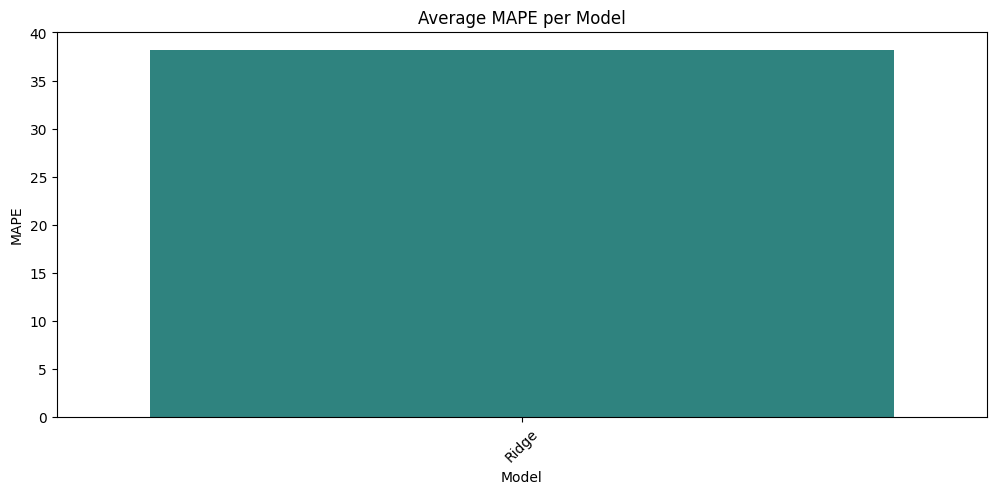

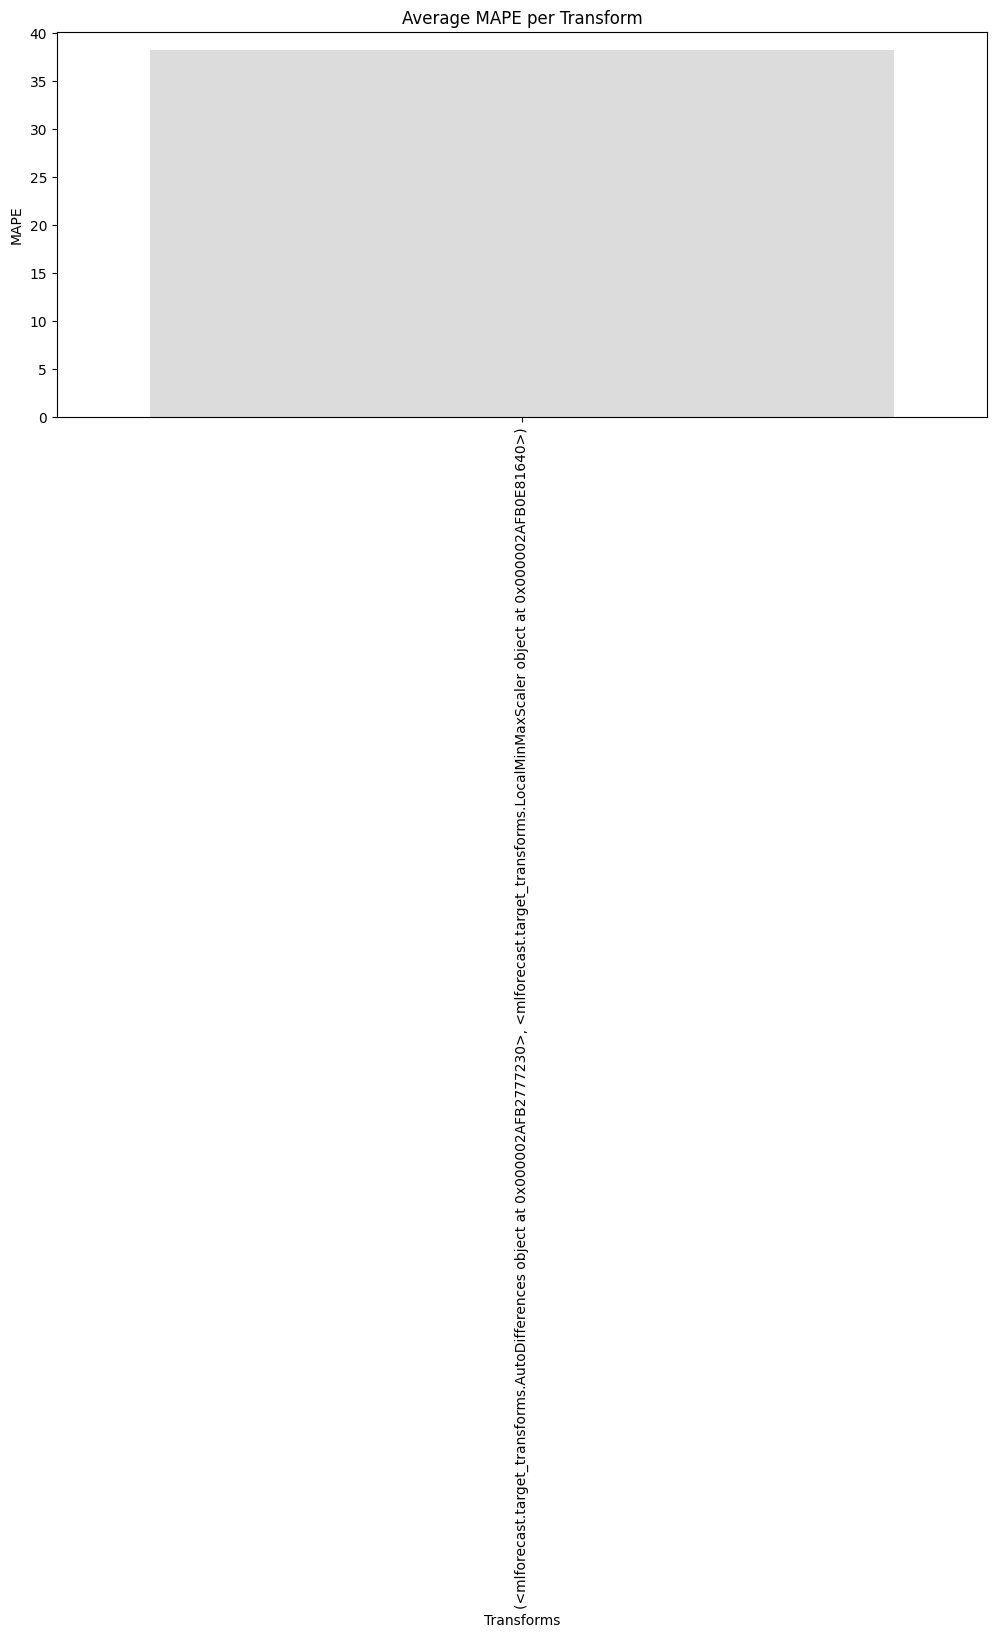

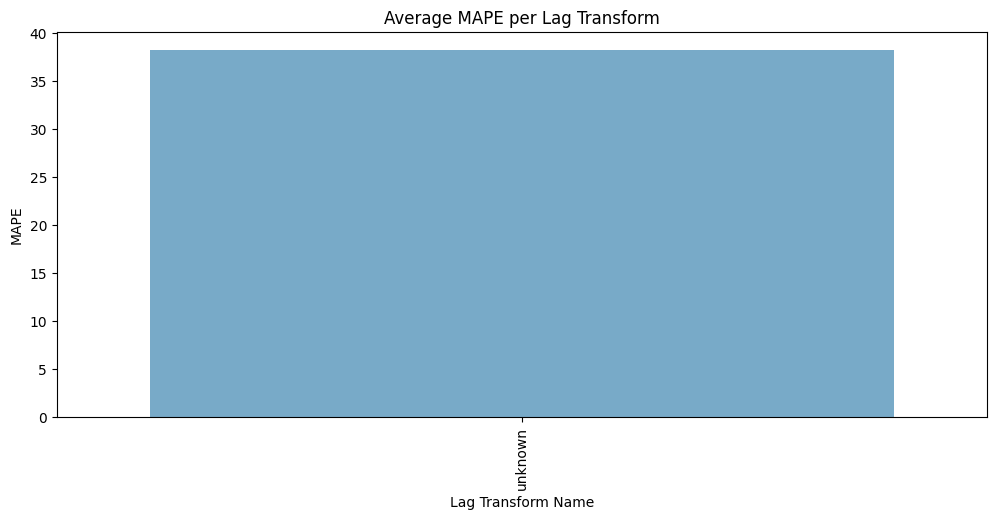

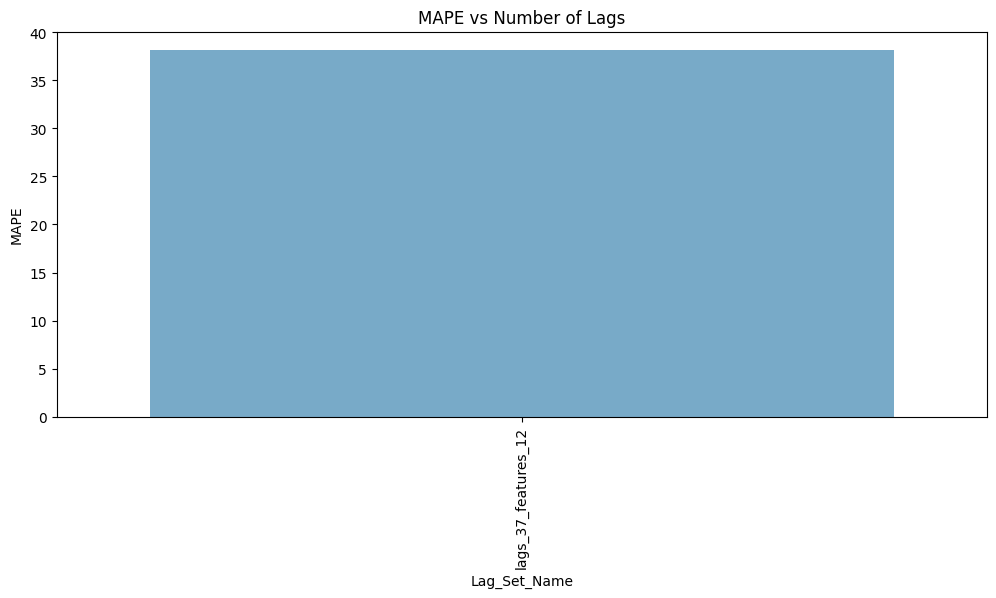

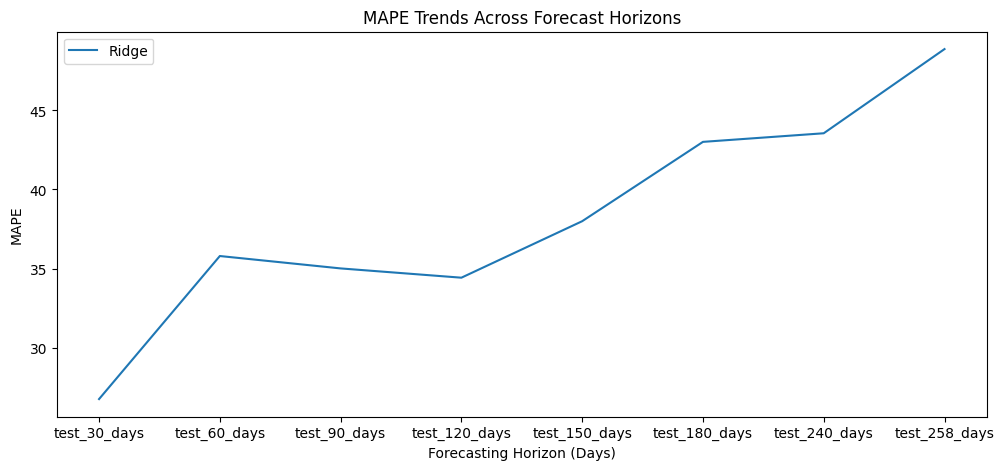

In [14]:
df = results['10M_train_9M_test'].copy()
top_models, top_transforms, top_lag_transforms, top_lags, mape_trends = analyze_results(df)
plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends)

In [15]:
df

,Model,Transforms,Lags,Lag Transforms,Lag Name,test_30_days,test_60_days,test_90_days,test_120_days,test_150_days,test_180_days,test_240_days,test_258_days
0,XGBRegressor,(),"[3, 4, 5, 7, 8, 9, 10, 20, 26, 31, 32, 33]",{1: [CPUDispatcher(<function expanding_mean at...,lags_37_features_12,58.640725,150.534383,243.257927,4.027687e+02,5.466450e+02,6.159868e+02,6.461620e+02,6.493676e+02
1,Ridge,(),"[3, 4, 5, 7, 8, 9, 10, 20, 26, 31, 32, 33]",{1: [CPUDispatcher(<function expanding_mean at...,lags_37_features_12,117.590165,382.799321,839.934478,1.841068e+03,3.295347e+03,4.625264e+03,7.144048e+03,8.137583e+03
2,Lasso,(),"[3, 4, 5, 7, 8, 9, 10, 20, 26, 31, 32, 33]",{1: [CPUDispatcher(<function expanding_mean at...,lags_37_features_12,108.639983,353.436428,775.350516,1.700226e+03,3.049317e+03,4.291209e+03,6.683289e+03,7.639102e+03
3,XGBRegressor,(),"[3, 4, 5, 7, 8, 9, 10, 20, 26, 31, 32, 33]",{1: [CPUDispatcher(<function rolling_mean_14 a...,lags_37_features_12,72.620157,184.052209,301.477283,4.816473e+02,6.513359e+02,7.342319e+02,7.637503e+02,7.692464e+02
4,Ridge,(),"[3, 4, 5, 7, 8, 9, 10, 20, 26, 31, 32, 33]",{1: [CPUDispatcher(<function rolling_mean_14 a...,lags_37_features_12,89.224035,279.009429,596.857446,1.302340e+03,2.370327e+03,3.421309e+03,5.822663e+03,6.913420e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,Ridge,(<mlforecast.target_transforms.AutoSeasonality...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{1: [CPUDispatcher(<function rolling_mean_14 a...,lags_150_features_150,655.187533,9114.506355,909004.827819,3.450118e+09,7.914194e+13,2.034905e+23,6.235707e+62,7.705906e+87
1616,Lasso,(<mlforecast.target_transforms.AutoSeasonality...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{1: [CPUDispatcher(<function rolling_mean_14 a...,lags_150_features_150,40.590567,45.173551,69.967014,1.241676e+02,1.778904e+02,2.032796e+02,2.094924e+02,2.105475e+02
1617,XGBRegressor,(<mlforecast.target_transforms.AutoSeasonality...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},lags_150_features_150,42.676647,110.667023,191.963946,3.180428e+02,4.376563e+02,4.959005e+02,5.160761e+02,5.197931e+02
1618,Ridge,(<mlforecast.target_transforms.AutoSeasonality...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},lags_150_features_150,655.345688,9120.948762,910092.078944,3.461980e+09,7.969993e+13,2.056882e+23,6.559372e+62,8.371736e+87


In [ ]:
'2020Q1'

In [30]:
file_path = r"waqi-airquality-2023Q1.csv"
import pandas as pd
# Read CSV while skipping comment lines
data = pd.read_csv(file_path, comment='#')
data = data.loc[data['City'] == "Almaty"]
# data = data.loc[data['Country'] == "KZ"]
data


,Date,Country,City,Specie,count,min,max,median,variance
19045,2023-03-02,KZ,Almaty,pm25,24,30.0,152.0,85.0,17507.80
19046,2023-01-17,KZ,Almaty,pm25,24,163.0,233.0,183.0,3391.14
19047,2023-01-19,KZ,Almaty,pm25,24,152.0,251.0,214.0,6746.79
19048,2023-01-27,KZ,Almaty,pm25,24,55.0,324.0,137.0,112810.00
19049,2023-02-03,KZ,Almaty,pm25,23,25.0,198.0,153.0,50453.80
...,...,...,...,...,...,...,...,...,...
19979,2023-01-04,KZ,Almaty,so2,24,1.7,2.7,2.0,0.99
19980,2023-01-30,KZ,Almaty,so2,23,1.6,2.4,2.0,0.60
19981,2023-02-05,KZ,Almaty,so2,24,1.5,2.7,1.9,0.78
19982,2023-03-28,KZ,Almaty,so2,24,1.4,2.8,1.7,1.25


,Date,Country,City,Specie,count,min,max,median,variance
182322,2018-06-23,KZ,Nur-Sultan,pm25,24,46.0,102.0,61.0,1282.32
182323,2018-06-05,KZ,Nur-Sultan,pm25,24,50.0,80.0,59.0,444.57
182324,2018-06-07,KZ,Nur-Sultan,pm25,24,50.0,85.0,61.0,733.84
182325,2018-06-12,KZ,Nur-Sultan,pm25,24,46.0,117.0,63.0,3431.88
182326,2018-06-13,KZ,Nur-Sultan,pm25,24,57.0,168.0,74.0,7253.90
182327,2018-06-15,KZ,Nur-Sultan,pm25,24,50.0,153.0,61.0,5409.40
182328,2018-06-04,KZ,Nur-Sultan,pm25,5,53.0,68.0,63.0,383.00
182329,2018-06-08,KZ,Nur-Sultan,pm25,24,55.0,153.0,70.0,3478.19
182330,2018-06-20,KZ,Nur-Sultan,pm25,24,55.0,137.0,68.0,5274.71
182331,2018-06-21,KZ,Nur-Sultan,pm25,24,46.0,153.0,68.0,4845.49
